# Objectifs du TP 2 : ACP fonctionnelle

- ACP des données "Canadian weather" avec les différentes approches vues en cours :
    - méthode 1 : directement sur les vecteurs de données
    - méthode 2 : en approchant chaque donnée par une B-spline sur une grille commune, puis en faisant une ACP classique
    - méthode 3 : en développant une ACP dans une base de fonctions
- Même objectifs pour des données "destructurées" (i.e. numération des CD4)

Pour cela, nous allons principalement utiliser deux packages python: ```skfda``` et ```scipy```.

In [1]:
from skfda import datasets
import matplotlib.pyplot as plt
import numpy as np
import random

### Chargement des données de températures du Canada

Nous allons en premier lieu manipuler le jeu de données "Canadian weather" issu du package skfda.

In [2]:
tableau, cat = datasets.fetch_weather(return_X_y=True, as_frame=True)
fd = tableau.iloc[:, 0].values
fd_temperatures = fd.coordinates[0] 


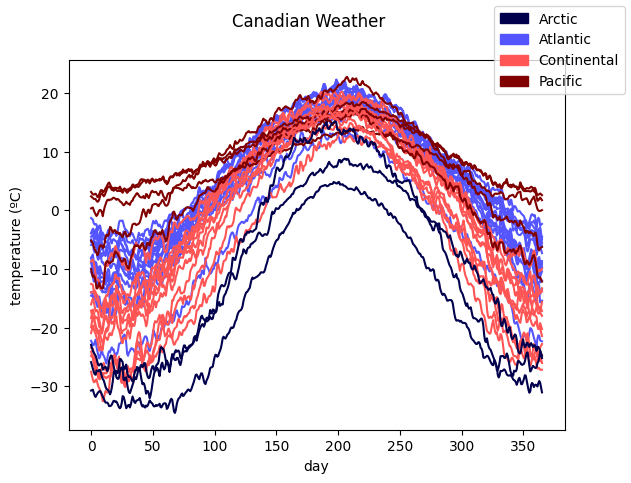

In [3]:
colormap = plt.colormaps['seismic']
label_names = cat.values.categories
nlabels = len(label_names)
label_colors = colormap(np.arange(nlabels) / (nlabels - 1))
label_cat = cat.values.codes

fd_temperatures.plot(group=label_cat, group_colors=label_colors,group_names=label_names)
plt.show()

# Important !

Afin d'illustrer correctement les différentes méthodes, nous allons utiliser pour chaque fonction seulement 100 points (correspondant à 100 jours) choisis aléatoirement : ce sont nos nouvelles données, qui ne sont pas définies sur la même grille.

À noter : il est toujours possible de définir une matrice de données, car chaque courbe de température sera approchée par 100 points exactement (problème lorsque le nombre de point par courbe est différent).

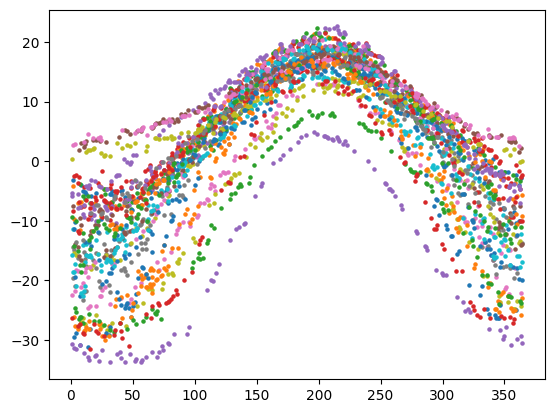

In [4]:
n = 35
temperatures = np.reshape(fd_temperatures.data_matrix, (n,365))
days = np.reshape(fd_temperatures.grid_points, (365))

n_support = 100
data = np.zeros((n, n_support))
t = np.zeros((n,n_support))

plt.figure()
for i in range(n):
    select_pts = random.sample(range(365), n_support)
    data[i,:] = temperatures[i, np.sort(select_pts)]
    t[i,:] = days[np.sort(select_pts)]
    plt.scatter(t[i,:], data[i,:], s = 5)
    
    

In [5]:
## On définit également un support "global" sur l'année sur lequel plotter nos données
t_global = np.linspace(0,365,n_support)

**Exercice + question :**
- Sur un même plot, afficher les données brutes (nuage de points), ainsi que les courbes associées sur le support global.
- Comment expliquez-vous la différence entre les courbes et les nuages de points?

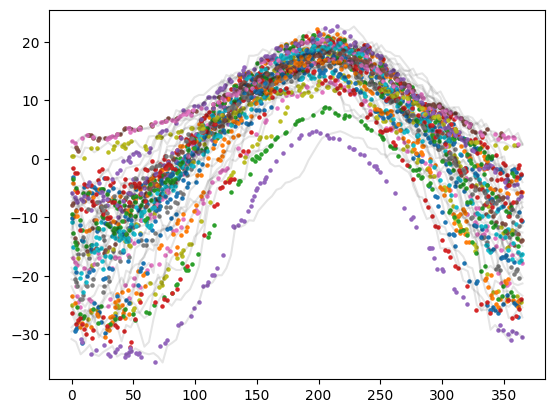

In [6]:

plt.figure()
for i in range(n):
    select_pts = random.sample(range(365), n_support)
    data[i,:] = temperatures[i, np.sort(select_pts)]
    t[i,:] = days[np.sort(select_pts)]
    plt.scatter(t[i,:], data[i,:], s = 5)

plt.plot(t_global, data.T, color = 'black', alpha = 0.1)
plt.show()

La différence entre les deux courbes sont dues au fait que nous affichons les courbes pointillées sur t_global, or t_global ne correspond pas aux grilles utilisées par les différents extraits de points (scatter) d'où les décalages qui sont en fait plt qui rapproche nos points sur le t global comme il peut

## 1ère méthode : ACP classique

**Exercice:**
- effectuer une ACP classique sur les données en considérant chaque "courbe" comme un vecteur de taille 100.
- tracer les deux premières composantes principales.
- tracer les projections des données sur les deux premières composantes principales.

In [7]:
## ACP
from sklearn.decomposition import PCA


# on standardise nos données : 
from sklearn.preprocessing import StandardScaler
values_cr = StandardScaler().fit_transform(np.transpose(data))

# On paramètre notre PCA pour garder les deux premières composantes
pca=PCA(2)
pca1_temps = pca.fit_transform(values_cr)
data_mean= np.mean(data,0)
pca1_temps.shape 
#pca.explained_variance_ratio_.sum()
#pca.components_(pca1_temps)


(100, 2)

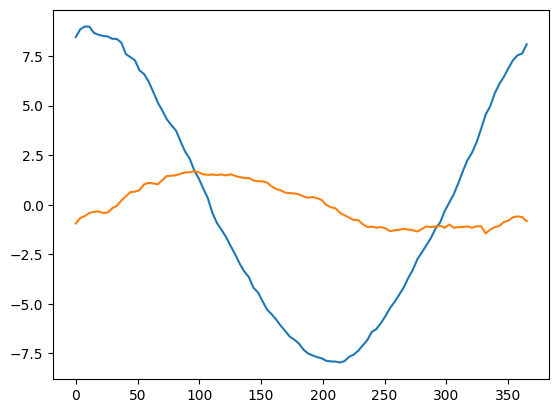

In [8]:
## Plot des deux premières composantes
plt.plot(t_global,pca1_temps[:,0])
plt.plot(t_global,pca1_temps[:,1])

In [9]:
## Plot des projections des données sur les deux premières composantes

proj_conv = np.dot(,pca1_temps())

SyntaxError: invalid syntax (3979360332.py, line 3)

## 2ème méthode : ACP classique sur les données lissées

**Exercice:**
- approcher chacun des vecteurs de données par une B-spline de degré 3
- interpoler ces splines sur $t_{\text{B-spline}} = [0,0.5,1,1.5,\ldots,364,364.5, 365]$
- effectuer une ACP classique sur ces nouveaux vecteurs (de plus grande dimension)
- tracer les deux premières composantes principales
- tracer les projections des données sur les deux premières composantes principales.

Pour représenter les données dans une base B-spline cubique (de degré 3), utiliser les fonctions ```splrep``` et ```BSpline```du package scipy.interpolate, avec un paramètre de régularisation $s=30$.

In [14]:
import scipy
import scipy.interpolate
## Approximation des vecteurs de données par B-spline de degré 3 et interpolation de ces splines sur t_Bspline
t_Bspline = np.arange(0.,364.5,0.5)
bsplines = np.zeros((n, len(t_Bspline)))
for i in range(n):
    t_knots,c,k = scipy.interpolate.splrep(t[i,:], data[i,:], k = 3,s=50)
    d = scipy.interpolate.BSpline(t_knots,c,k)
    bsplines[i,:] = d(t_Bspline)

In [15]:
## ACP sur "vecteurs régularisés"

mean_bsplines = np.mean(bsplines, axis = 0)
X= bsplines - mean_bsplines
[V,D] = np.linalg.eig(np.dot(X.T,X)/bsplines.shape[0])
V, D = V.real, D.real

V = np.diag(V)


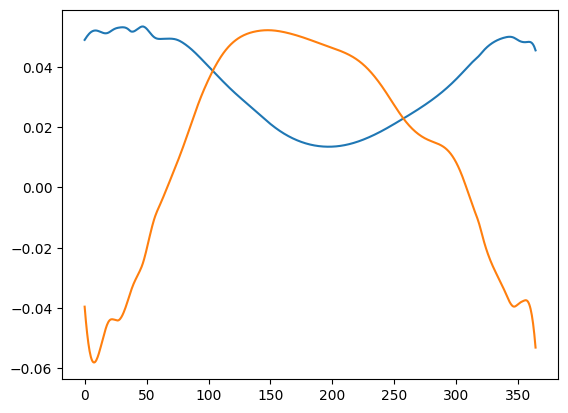

In [16]:
## Plot des deux premières composantes

plt.figure()
plt.plot(t_Bspline,D[:,0])
plt.plot(t_Bspline,D[:,1])
plt.show()

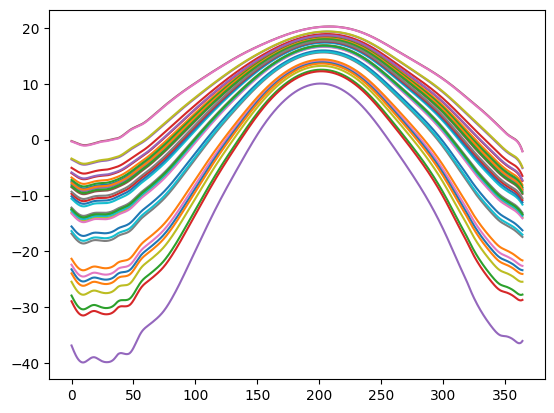

In [20]:
## Plot des projections des données sur les deux premières composantes

proj = np.dot(X,D)

plt.figure()
for i in range(n):
    data_proj_1 = mean_bsplines + proj[i,0]*D[:,0]
    plt.plot(t_Bspline,data_proj_1)
for i in range(n):   
    data_proj_2 = mean_bsplines + proj[i,1]*D[:,1]
    plt.plot(t_Bspline,data_proj_2)
plt.show()


**Exercice:** Comparer sur une même figure:
- les composantes principales par l'ACP classique (méthode 1), régularisées a posteriori par Bspline (et interpolées sur $t_{\text{B-spline}}$)
- les composantes principales obtenues après approximations par Bspline des vecteurs de données (méthode 2)

In [ ]:
## Approximation par Bspline des deux premières composantes principales obtenues par l'ACP classique

...

In [ ]:
## Comparaison des composantes principales lissées par Bspline après ACP et des composantes principales obtenues
# en ayant lisser les données avant l'ACP.

...

# 3ème méthode : ACP sur une base de fonctions en utilisant skfda

In [ ]:
## Utilisation du package skfda pour la définition d'une base de fonction Bspline

from skfda.representation.basis import BSplineBasis
from skfda.representation.basis import FDataBasis

nb_basis = 30
basis = BSplineBasis(n_basis = nb_basis, order = 4)

In [ ]:
## Expression des données dans une base de fonctions commune

basis_coeff = np.zeros((n,nb_basis))
for i in range(n):
    coef = FDataBasis.from_data(..., ..., ...)
    basis_coeff[i,:] = coef.coefficients
data_fpca = FDataBasis(..., ...)

...

**Exercice:** Via la fonction ```FPCA``` du package ```skfda```, récupérer les deux premières composantes principales obtenues par ACP dans la base de fonctions ```Bspline```, et les plotter.

In [ ]:
...

**Question :** Qu'en déduisez-vous?

# Application de la méthode 3 (ACP fonctionnelle) sur les données CD4

Tiré de l'étude MACS (Multicenter AIDS Cohort Study), l'ensemble de données sur la numération des cellules CD4 recueille le nombre de cellules CD4 par millilitre de sang de $N = 366$ patients. Les cellules CD4 sont un type particulier de globules blancs et sont des composants clés du système immunitaire. Le VIH attaque les cellules CD4 dans le sang du patient. Le nombre de cellules CD4 peut donc être considéré comme une mesure de la progression de la maladie. Pour cet ensemble de données, le nombre de cellules CD4 est mesuré environ deux fois par an et centré sur le moment de la séroconversion, qui est le moment où le VIH devient détectable. Pour chaque individu, le nombre de mesures varie de 1 à 11 sur une période de 18 mois avant et 42 mois après la séroconversion. Les points d'échantillonnage sont différents d'une observation à l'autre.

In [ ]:
import pandas as pds
cd4 = pds.read_csv('cd4.csv', index_col=0)
all_argvals = cd4.columns.astype(np.int64)
argvals = {idx:np.array(all_argvals[~np.isnan(row)]) for idx, row in enumerate(cd4.values)}
values = {idx:row[~np.isnan(row)] for idx, row in enumerate(cd4.values)}
nb_patients = len(argvals)

In [ ]:
## Suppression des patients qui ont un nombre d'observations $\leq 3$.

patients_out = []

for i in np.arange(nb_patients):
    if len(argvals[i]) < 4:
        del argvals[i]
        del values[i]
        patients_out.append(i)

patients = np.arange(nb_patients)
patients = np.delete(patients, patients_out)

nb_patients = len(patients)

**Exercice:** Afficher les observations des 20 premiers patients.

In [ ]:
...

**Exercice :** Calculer [min_temps, max_temps], l'intervalle maxixal de points d'échantillonage, tout patient confondu.

In [ ]:
...

**Exercice :** Approcher les observations par des Bpline, sur l'intervalle maximal des temps d'observations des patients, en interpolant sur ```temps = np.linspace(min_temps, max_temps, 100)```.

In [ ]:
temps = np.linspace(min_temps, max_temps, 100)
cd4_lisse = np.zeros((nb_patients,100))

for i, pat in enumerate(patients):
    nn, c, k = splrep(argvals[pat], values[pat], s = 70)
    B = BSpline(nn, c, k)
    cd4_lisse[i,:] = B(temps)
    
plt.plot(temps,cd4_lisse.T)
plt.show()

**Question :** Que remarquez-vous? Et qu'en déduisez-vous?

**Exercice :** Refaire une approximation par Bspline sans extrapoler en dehors de l'enveloppe convexe du support des fonctions (voir les paramètres de la fonction BSpline).

In [ ]:
for i, pat in enumerate(patients):
    nn, c, k = splrep(argvals[pat], values[pat], k = 3, s = 20)
    B = BSpline(nn, c, k, extrapolate = False)
    cd4_lisse[i,:] = B(temps)
plt.plot(temps,cd4_lisse[:10,:].T)

for i, pat in enumerate(patients[:10]):
    plt.scatter(argvals[pat], values[pat])
plt.show()

**Remarque:** Il est primordial que les fonctions aient une base commune afin de pouvoir les comparer!

Nous utiliserons une base de Fourier ici.

In [ ]:
from skfda.representation.basis import FourierBasis
from skfda.representation.basis import FDataBasis


nb_basis = 3
basis = FourierBasis(domain_range = (min_temps, max_temps), n_basis = nb_basis)


**Exercice :** Calculer les coefficients de chaque courbe dans la base de Fourier en utilisant ```FDataBasis.from_data```

In [ ]:
...

**Exercice :** En utilisant la fonction ```FDataBasis``` tracer les courbes dans la base de Fourier, puis tracer les deux premières composantes principales en utilisant la fonction ```FPCA``` de ```skfda.preprocessing.dim_reduction```.


In [ ]:
...

In [ ]:
...

**Exercice :** tracer les projections des données sur les deux premières composantes principales.

In [ ]:
...

